In [13]:
! pip install requests

In [14]:
! pip install pandas

In [15]:
import requests
import json
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import math as math

## 結果データを取得する

In [16]:
def getResultData(id):
    try:
        response = requests.get(f'https://oyster-app-8jboe.ondigitalocean.app/therb/{id}')
        data = json.loads(response.text)
        #data = json.loads(response.text)
        #jsonデータをpandasのdataframeに変換する
        return data['data']
    except:
        throw('no id matches data in database')

getResultDataに渡すidはtherb-frontendのUIのここから取得できます
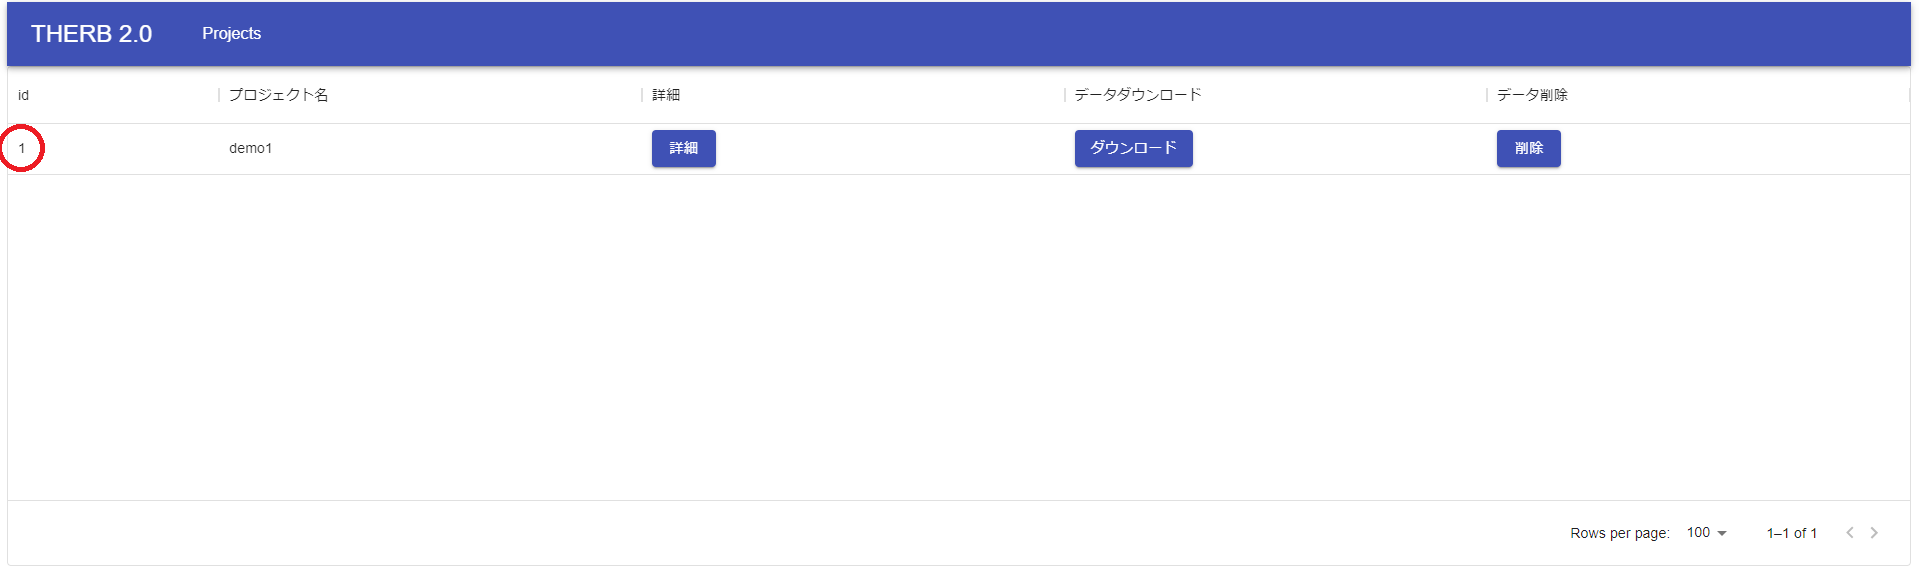

In [18]:
resultData = getResultData(10)
#resultData#["results"]["time"]
resultData

[{'roomId': 'outdoor',
  'results': {'time': ['01/05/24:00',
    '01/06/01:00',
    '01/06/02:00',
    '01/06/03:00',
    '01/06/04:00',
    '01/06/05:00',
    '01/06/06:00',
    '01/06/07:00',
    '01/06/08:00',
    '01/06/09:00',
    '01/06/10:00',
    '01/06/11:00',
    '01/06/12:00',
    '01/06/13:00',
    '01/06/14:00',
    '01/06/15:00',
    '01/06/16:00',
    '01/06/17:00',
    '01/06/18:00',
    '01/06/19:00',
    '01/06/20:00',
    '01/06/21:00',
    '01/06/22:00',
    '01/06/23:00',
    '01/06/24:00',
    '01/07/01:00',
    '01/07/02:00',
    '01/07/03:00',
    '01/07/04:00',
    '01/07/05:00',
    '01/07/06:00',
    '01/07/07:00',
    '01/07/08:00',
    '01/07/09:00',
    '01/07/10:00',
    '01/07/11:00',
    '01/07/12:00',
    '01/07/13:00',
    '01/07/14:00',
    '01/07/15:00',
    '01/07/16:00',
    '01/07/17:00',
    '01/07/18:00',
    '01/07/19:00',
    '01/07/20:00',
    '01/07/21:00',
    '01/07/22:00',
    '01/07/23:00',
    '01/07/24:00',
    '01/08/01:00',
    '01/

部屋ごとにデータを整理できるようにする必要

In [3]:
def convertToDataframe(resultDict):
    columns = []
    rows = []
    for k,v in resultDict.items():   #ディクショナリーに入っているkeyとitemでループする。列と行で室ごとに入れている。
        columns.append(k)
        rows.append(v)
    print (columns)
    #transposedRows = np.array(rows,dtype=np.float32).T:転置行列　Flipmatrix in GH　
    #参考URL：https://note.nkmk.me/python-numpy-transpose/
    #ここで、n行1列を1行n列に変換している(Pandasのデータ構造に合わせる為)
    transposedRows = np.array(rows).T
    df = pd.DataFrame(data = transposedRows, columns = columns) 
    #DataFrame,DataFrameとはhttps://docs.pyq.jp/python/pydata/pandas/dataframe.html
    #indexで列ってのは何を表しているかを表示させている。表の時間項目の一番上：https://note.nkmk.me/python-pandas-set-index/
    df=df.set_index('time')
    df=df.astype('float32')
    #return transposedRows
    return df

In [5]:
def dataFrameByKey(resultDataList,columnName):
    tempData = []
    columns=[]
    for resultData in resultDataList:
        df = convertToDataframe(resultData["results"])
        try:
            tempData.append(df[columnName])
            columns.append(resultData["roomId"])
        except:
            pass
    df=pd.concat(tempData,axis=1)
    df.columns = columns
    return df

In [19]:
temperaturedf=dataFrameByKey(resultData,"temp")

['time', 'temp', 'relHumidity', 'absHumidity']
['time', 'temp', 'relHumidity', 'absHumidity', 'sensibleLoad', 'latentLoad']
['time', 'temp', 'relHumidity', 'absHumidity', 'sensibleLoad', 'latentLoad']
['time', 'temp', 'relHumidity', 'absHumidity', 'sensibleLoad', 'latentLoad']


In [20]:
temperaturedf["outdoor"]

time
01/05/24:00     8.4
01/06/01:00     8.4
01/06/02:00     8.3
01/06/03:00     8.3
01/06/04:00     8.2
               ... 
12/26/20:00    10.4
12/26/21:00     9.7
12/26/22:00     9.3
12/26/23:00     9.0
12/26/24:00     8.5
Name: outdoor, Length: 8521, dtype: float32

In [10]:
humiditydf=dataFrameByKey(resultData,"relHumidity")

['time', 'temp', 'relHumidity', 'absHumidity']
['time', 'temp', 'relHumidity', 'absHumidity', 'sensibleLoad', 'latentLoad']
['time', 'temp', 'relHumidity', 'absHumidity', 'sensibleLoad', 'latentLoad']


In [11]:
#ComfortZoneかどうかの判断の為の関数。roomIdを入れると、それに満たす配列が出てくる。
def JudgeComfort(roomId):
    dfAll=pd.merge(temperaturedf,humiditydf,how = "left",on="time")
    Columnsname=dfAll.filter(like=roomId,axis=1).columns.values
    df=dfAll.loc[:,Columnsname]
    #setting ComfortZone from Temperature and relativeHumidity,-1=Humidity,-2=temperature
    Judgecomfortzonedf=df[(df.iloc[:, -1]<60)&(df.iloc[:, -1]>30)&(df.iloc[:, -2]<10.4)]
    temperaturearray=Judgecomfortzonedf.iloc[:, -2].values
    humidityarray=Judgecomfortzonedf.iloc[:, -1].values
    return [temperaturearray,humidityarray]

In [12]:
#Natural Ventilationかどうかの判断の為の関数。roomIdを入れると、それに満たす配列が出てくる。
#解析データからだと算出できない。
dfAll=pd.merge(temperaturedf,humiditydf,how = "left",on="time")
Columnsname=dfAll.filter(like="room1",axis=1).columns.values #なぜaxisが位置だとうまくいくのか調べる
df=dfAll.loc[:,Columnsname]
date=df.index.values
# Firstdate,LastDate=date[0],date[-1]
# period=LastDate-Firstdate

In [14]:
#Natural Thermal MassZoneであるかどうかの判定
def JudgeNaturalVentilation(roomId):
        dfAll=pd.merge(temperaturedf,humiditydf,how = "left",on="time")
    Columnsname=dfAll.filter(like=roomId,axis=1).columns.values
    df=dfAll.loc[:,room1Columnsname]
    #setting ComfortZone from Temperature and relativeHumidity,-1=Humidity,-2=temperature
    

IndentationError: unindent does not match any outer indentation level (<tokenize>, line 4)

In [ ]:
# a_list = []
# for i in range(10):
#     child_list = []
#     a_list.append(child_list)
#     for j in range(20):
#         child_list.append([i, j])

# # 内包表記バージョン
# a_list = [[[i, j] for j in range(20)] for i in range(10)]

In [ ]:
#空気線図にプロットする時に使用
def dfArray(df,roomId):
    df=df[roomId]
    array=[]
    for i in range(len(df.index)):
        array.append(df.iloc[i])
    return array

In [ ]:
temparray=dfArray(temperaturedf,"room1")
humarray=dfArray(humiditydf,"room1")

In [ ]:
#これで、ディクショナリーから欲しい情報を抽出している。
tempDict={}
humidityDict={}
for roomId in temperaturedf.columns:
    if roomId != "outdoor":
        tempDict[roomId]= temperaturedf[roomId].tolist()
        humidityDict[roomId]=humiditydf[roomId].tolist()

In [ ]:
# ComfortDict={}
# for roomId in temperaturedf.columns:
#     ComfortDict[roomId]= temperaturedf[roomId].tolist()
# print (ComfortDict.keys())

In [ ]:
from pythermalcomfort.models import pmv
from pythermalcomfort.utilities import v_relative, clo_dynamic

In [ ]:
#ステップ2 それぞれの部屋のデータに関してPMVの算出を自動で行う。
#まさかのステップ3  情報をディクショナリーに登録する。
#多重辞書について：https://kenken-python.com/python-multi-dic/
#Def関数にする。
##Def関数やと、あくまで定義を登録してるわけで関数を実行しているわけではないからディクショナリーを行うときは関数を呼ぶ必要がある！
from pythermalcomfort.models import pmv_ppd
from pythermalcomfort.models import pmv
from pythermalcomfort.utilities import v_relative, clo_dynamic
#PMV*を計算する。
def CalculatePMV_PPD():
    #pmvDict={}
    for roomId in tempDict.keys():
    #    print (tempDict[roomId])
    #    print (humidityDict[roomId])
        tdb = tempDict[roomId]
        tr = tempDict[roomId]
        rh = humidityDict[roomId]
        v = 0.05
        met = 1
        clo = 2.0
        #print (tdb)
        # calculate relative air speed
        v_r = v_relative(v=v, met=met)
        # calculate dynamic clothing
        clo_d = clo_dynamic(clo=clo, met=met)
        results = pmv_ppd(tdb=tdb, tr=tr, vr=v_r, rh=rh, met=met, clo=clo_d, limit_inputs=False)
        CalculateComfort[str(roomId)]= results
        CalculateComfort[str(roomId)]["time"]=resultData[0]["results"]["time"]
        #元のデータに追加している。
        #pmvDict[roomId]=results
        #print (results)

In [ ]:
#SET*を計算する。
from pythermalcomfort.models import set_tmp
def CalculateSET():
    for roomId in tempDict.keys():
        tdb = tempDict[roomId]
        tr = tempDict[roomId]
        rh = humidityDict[roomId]
        v = 0.05
        met = 1
        clo = 2.0
        v_r = v_relative(v=v, met=met)
        clo_d = clo_dynamic(clo=clo, met=met)
        results=set_tmp(tdb=tdb, tr=tr, v=v_r, rh=rh, met=met, clo=clo_d,limit_inputs=False)
        CalculateComfort[str(roomId)]["SET*"]= results

In [ ]:
#UTCIを計算する。風速はどうするかは相談すべし
OutTem=temperaturedf["outdoor"].tolist()
Outhum=humiditydf["outdoor"].tolist()
from pythermalcomfort.models import utci
def CalculateUTCI():
    # for users who wants to get stress category
    results=utci(tdb=OutTem, tr=OutTem, v=2.0, rh=Outhum, return_stress_category=True)
    CalculateComfort["outdoor"]= results
    CalculateComfort["outdoor"]["time"]=resultData[0]["results"]["time"]

In [ ]:
#UWBGTを計算する。風速はどうするかは相談すべし
# OutTem=temperaturedf["outdoor"].tolist()
# Outhum=humiditydf["outdoor"].tolist()

In [ ]:
#関数を起動させるためのもの_ここで関数を起動
CalculateComfort={}
#CalculateOutdoor={}
CalculatePMV_PPD()
CalculateSET()
CalculateUTCI()

In [ ]:
CalculateComfort

In [ ]:
SeparateRoomAndResults=[]
for roomId in tempDict.keys():
    ReCalculateComfort={"roomId":{},"results":{}}
    ReCalculateComfort["roomId"]=roomId
    for keys in CalculateComfort[roomId]:
        ReCalculateComfort["results"][str(keys)]=CalculateComfort[roomId][str(keys)]
    SeparateRoomAndResults.append(ReCalculateComfort)
pmvdf=dataFrameByKey(SeparateRoomAndResults,"SET*")
pmvdf

In [ ]:
#室内データについてデータ形式をPandasに変更
SeparateRoomAndResults=[]
for roomId in tempDict.keys():
    ReCalculateComfort={"roomId":{},"results":{}}
    ReCalculateComfort["roomId"]=roomId
    for keys in CalculateComfort[roomId]:
        ReCalculateComfort["results"][str(keys)]=CalculateComfort[roomId][str(keys)]
    SeparateRoomAndResults.append(ReCalculateComfort)
setdf=dataFrameByKey(SeparateRoomAndResults,"SET*")
setdf

In [ ]:
#SeparateRoomAndResults.append(ReCalculateComfort*len(CalculateComfort.keys())):
ReCalculateComfort={"roomId":{},"results":{}}
ReCalculateComfort["roomId"]=("outdoor")
for keys in CalculateComfort["outdoor"]:
    ReCalculateComfort["results"][str(keys)]=CalculateComfort["outdoor"][str(keys)]
ReCalculateComfort

In [ ]:
# #PmvとPPDのチャートを生成
# #1_ポイントとなるPMVとPPDの位置を生成。

# x1= np.array(CalculateComfort['room1']['pmv'])
# y1= np.array(CalculateComfort['room1']['ppd'])
# #2描写範囲の設定
# fig = plt.figure()
# #ax.set_xlim(left=-3.0, right=3.0)
# #plt.xlim(-3, 3)
# #軸の名前
# plt.xlabel("PMV", fontsize=20)
# #ax.set_ylim(bottom=0, top=100)
# plt.ylim(0, 100)
# plt.ylabel("PPD[%]", fontsize=20)
# #ax=fig.add_subplot(1,1,1)
# # (8)目盛線の表示
# plt.grid(True)
# # #関数の表示__したいけど、上手くいかない。
# x = np.linspace(-3,3,200)
# def y(a):
#     return np.exp(a)
# y1 = 100-95*y(-0.03353*(x**4)-0.2179*(x**2))
# fig = plt.figure()
# ax = fig.add_subplot(1,1,1)
# ax.plot(x,y1,"-")
# plt.show
# # #3_ここで描画する。
# #plt.scatter(x1,y1,s=10,alpha=0.5,linewidths=2,marker=".",c='#aaaaFF',edgecolors='blue')
# # ax = fig.add_subplot(111)
# # ax.axvspan(-0.5, 0.5, 0, 10, color = "coral")
# #plt.show()

In [ ]:
#range関数は小数点にすることが出来ない。
import math
for i in  range(-300,300,5):
    x=i*0.01
    y = 100-95*math.exp(-0.03353*(x**4)-0.2179*(x**2))
    print (y)

In [16]:
#PmvとPPDのチャートを生成
#1_ポイントとなるPMVとPPDの位置を生成。
x1= np.array(CalculateComfort['room1']['pmv'])
y1= np.array(CalculateComfort['room1']['ppd'])
print(type(x1))
#2描写範囲の設定
fig = plt.figure()

#軸の領域(-3<x<3)
plt.xlim(-3, 3)
#軸の名前
plt.xlabel("PMV", fontsize=20)
plt.ylim(0, 100)
plt.ylabel("PPD[%]", fontsize=20)

#目盛線(grid)の表示
plt.grid(True)
#関数の表示(PPDとPMVの関数の表示)
xl1 = np.linspace(-3,3,200) #x軸のlineという意味
def y(a):
    return np.exp(a)
yl1 = 100-95*y(-0.03353*(xl1**4)-0.2179*(xl1**2))

#快適域の表示
xc1= np.linspace(-0.5,0.5,200)
yc1= 10

#3_ここで描画する。
plt.scatter(x1,y1,s=10,alpha=0.5,linewidths=2,marker=".",c='#aaaaFF',edgecolors='red',label="ObservationPoints")
plt.plot(xl1,yl1,linestyle="solid",color="black",linewidth=0.3)
plt.fill_between(xc1,yc1,where=yc1>xc1,facecolor='#66FF99',alpha=0.5,label="ComfortArea")
plt.legend()
plt.legend(bbox_to_anchor=(0, 1), loc='upper left', borderaxespad=1, fontsize=10)

plt.show()
print ("快適範囲に含まれる時間は0%存在します。")

NameError: name 'CalculateComfort' is not defined

In [15]:
#1/6.0:00~1/6.24:00までのデータが取れたと仮定
#データ1
yd1=np.array(CalculateComfort['room1']['pmv'])
yd2=yd1[0:25]  #ここも動的に変化が必要
xd1=np.arange(0,25)
plt.ylim(-3, 3)
plt.ylabel("PMV", fontsize=20)
plt.xlabel("datetime_1_6", fontsize=20)
plt.grid(True)
#描写
xc1= np.linspace(0,25,10)
yc1= 0.5
yc2= -0.5
plt.scatter(xd1,yd2,s=10,alpha=0.5,linewidths=2,marker=".",c='#aaaaFF',edgecolors='red',label="ObservationPoints")
plt.fill_between(xc1,yc1,yc2,color = "#66FF99", alpha = 0.5,label="ComfortArea")
plt.legend()
plt.legend(bbox_to_anchor=(0, 1), loc='upper left', borderaxespad=1, fontsize=10)
plt.show()

NameError: name 'CalculateComfort' is not defined

In [ ]:
#何かしらで暑い日がいつなのか算出し、データが取れたと仮定
#イメージとしては、一番暑い日、一番寒い日を算出して、前後1日を取った計3日間を算出するイメージ
#デー
yd1=temperaturedf["room1"]["01/05/24:00":"01/08/24:00"] #データを算出する。
xd1=np.arange(0,72)
plt.xlabel("DateTime_1_6___1_8", fontsize=20)
plt.ylabel("Temperature", fontsize=20)
plt.grid(True)
#描写
xct1= np.linspace(0,72,73)
yct1= 28
yct2= 17
plt.scatter(xd1,yd1,s=10,alpha=0.5,linewidths=2,marker=".",c='#aaaaFF',edgecolors='red',label="ObservationPoints")
plt.fill_between(xc1,yc1,yc2,color = "#66FF99", alpha = 0.5,label="ComfortArea")

In [ ]:
#これでもできるが、これだとデータが背離りていしまう。
len(resultData)-1

In [22]:
tempArray = temparray
humidArray =humarray
points_array = {'points_series_name': (tempArray, humidArray)}
points_array

NameError: name 'temparray' is not defined

In [21]:
%matplotlib inline
from psychrochart import PsychroChart

from psychrochart import load_config
config_style = load_config('default')
from psychrochart import load_zones
config_zone = load_zones()
config_zone['zones'].pop()
points_style = {'s': 9, 'alpha': 0.8, 'color': 'darkorange'}
chart = PsychroChart(config_style, config_zone)
ax = chart.plot()
chart.plot_points_dbt_rh(points_array, scatter_style=points_style)
ax.get_figure()

C:\Users\81803\anaconda3\lib\site-packages\psychrochart\chart.py:533: MatplotlibDeprecationWarning: Calling gca() with keyword arguments was deprecated in Matplotlib 3.4. Starting two minor releases later, gca() will take no keyword arguments. The gca() function should only be used to get the current axes, or if no axes exist, create new axes with default keyword arguments. To create a new axes with non-default arguments, use plt.axes() or plt.subplot().
  ax = self.figure.gca(position=position)


NameError: name 'points_array' is not defined

## とりあえず折れ線グラフで可視化してみる

In [ ]:
! pip install matplotlib seaborn

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns

### データをすぐに確認するのはpandasのほうが早い

In [ ]:
df_room1['temp'].plot.line(figsize=(20,10))
type df_room1

どの温度の時間帯が多いか？

In [ ]:
df_room2['temp'].plot.line(figsize=(20,10))

In [ ]:
df_room1['temp'].hist(figsize=(20,10),bins=30)

### 快適時間帯の割合は？

In [ ]:
def calcPercentage(data,min,max):
    maxSatisfied = data[lambda x: x<max]
    satisfied = maxSatisfied[lambda x: x>min]
    percentage = len(satisfied)/len(data)*100
    return round(percentage,1)

In [ ]:
calcPercentage(df_room1['temp'],20,28)

In [ ]:
calcPercentage(df_room2['temp'],20,28)

In [ ]:
calcPercentage(df_room1['temp'],20,28)

### visualizeの見栄えをよくする

In [ ]:
plt.plot(df_room1.index,df_room1['temp'],label = "temp")
plt.plot(df_room2.index,df_room2['temp'],label = "aaa")
print (type(df_room1.index,df_room1['temp']))

#### Seabornは時間がかかりすぎ

In [ ]:
plt.figure(figsize=(20, 10))
sns.lineplot(data=df, x="hour", y="roomT")

In [ ]:
#psychrochartを使ってPythonで湿り空気線図を書く
#https://zenn.dev/kinonotofu/articles/210f2835d9a6e3

! pip install psychrochart

In [ ]:
config_zone